In [1]:
# Import library yang diperlukan
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load data ke dalam data frame dan spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_stopword kecuali-stemming_terpisah.csv', encoding='latin-1') 

df.head()

,review_tokens_stemmed,Sentimen,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,kecewa banget pesan free pouch kirim cotton pa...,Negatif,{'classified_text': 'kecewa [-4] banget pesan ...,kecewa [-4] banget pesan free pouch kirim cott...,kecewa banget pesan free pouch kirim cotton p...,['kecewa [-4] banget pesan free pouch kirim co...,5,-4,positif
1,kali emas tidak safe seperti tutup botol tidak...,Negatif,{'classified_text': 'kali emas [5] tidak safe ...,kali emas [5] tidak safe seperti [1] tutup bot...,kali emas tidak safe seperti tutup botol tida...,['kali emas [5] tidak safe seperti [1] tutup b...,5,-3,positif
2,paket datang barang pecah return seller ikut k...,Negatif,{'classified_text': 'paket datang barang pecah...,paket datang barang pecah [-2] return seller i...,paket datang barang pecah return seller ikut ...,['paket datang barang pecah [-2] return seller...,1,-4,negatif
3,enggak sabun nya enggak sesuai deskripsi,Negatif,{'classified_text': 'enggak sabun nya enggak s...,enggak sabun nya enggak sesuai [-3] deskripsi,enggak sabun nya enggak sesuai deskripsi,['enggak sabun nya enggak sesuai [-3] deskripsi'],1,-3,negatif
4,enggak sesuai harap,Negatif,{'classified_text': 'enggak sesuai [-3] harap'...,enggak sesuai [-3] harap,enggak sesuai harap,['enggak sesuai [-3] harap'],1,-3,negatif


In [3]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:8], axis=1)

# Cek data teratas
df.head()

,review_tokens_stemmed,kelas
0,kecewa banget pesan free pouch kirim cotton pa...,positif
1,kali emas tidak safe seperti tutup botol tidak...,positif
2,paket datang barang pecah return seller ikut k...,negatif
3,enggak sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harap,negatif


In [4]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens_stemmed' : 'Review',
    'kelas' : 'Sentimen'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch kirim cotton pa...,positif
1,kali emas tidak safe seperti tutup botol tidak...,positif
2,paket datang barang pecah return seller ikut k...,negatif
3,enggak sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harap,negatif


In [5]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    141
netral      61
negatif     45
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    247 non-null    object
 1   Sentimen  247 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None


              Review Sentimen
count            247      247
unique           238        3
top     terima kasih  positif
freq               3      141


In [6]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch kirim cotton pa...,2
1,kali emas tidak safe seperti tutup botol tidak...,2
2,paket datang barang pecah return seller ikut k...,0
3,enggak sabun nya enggak sesuai deskripsi,0
4,enggak sesuai harap,0


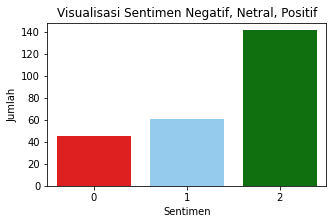

In [7]:
# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [8]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [9]:
# Inisialisasi model
cnb = ComplementNB(alpha=1.0 , fit_prior=True, class_prior=None)

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions_testing = []
all_true_labels_testing = []
all_predictions_training = []
all_true_labels_training = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = vectorizer.fit_transform(X_train)
    X_test_transform = vectorizer.transform(X_test)

    # Melatih model klasifikasi pada data latih
    cnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions_testing = cnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_testing.extend(predictions_testing)
    all_true_labels_testing.extend(y_test)

    # Membuat prediksi pada data training
    predictions_training = cnb.predict(X_train_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_training.extend(predictions_training)
    all_true_labels_training.extend(y_train)

In [10]:
# Hitung metrik evaluasi
accuracy_training = accuracy_score(all_true_labels_training, all_predictions_training)
precision_training = precision_score(all_true_labels_training, all_predictions_training, average='weighted')
recall_training = recall_score(all_true_labels_training, all_predictions_training, average='weighted')
f1_training = f1_score(all_true_labels_training, all_predictions_training, average='weighted')

# Print hasil
print("------- AKURASI TRAINING -------")
print("Overall accuracy:", accuracy_training)
print("Overall precision:", precision_training)
print("Overall recall:", recall_training)
print("Overall F1-score:", f1_training)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_training, all_predictions_training)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_training, all_predictions_training, zero_division=0))


------- AKURASI TRAINING -------
Overall accuracy: 0.9284750337381916
Overall precision: 0.9324672731982375
Overall recall: 0.9284750337381916
Overall F1-score: 0.9255304900035967
Confusion Matrix : 
 [[ 391    0   14]
 [  47  411   91]
 [   0    7 1262]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       405
           1       0.98      0.75      0.85       549
           2       0.92      0.99      0.96      1269

    accuracy                           0.93      2223
   macro avg       0.93      0.90      0.91      2223
weighted avg       0.93      0.93      0.93      2223



In [11]:
# Hitung metrik evaluasi
accuracy_testing = accuracy_score(all_true_labels_testing, all_predictions_testing)
precision_testing = precision_score(all_true_labels_testing, all_predictions_testing, average='weighted')
recall_testing = recall_score(all_true_labels_testing, all_predictions_testing, average='weighted')
f1_testing = f1_score(all_true_labels_testing, all_predictions_testing, average='weighted')

# Print hasil
print("------- AKURASI TESTING -------")
print("Overall accuracy:", accuracy_testing)
print("Overall precision:", precision_testing)
print("Overall recall:", recall_testing)
print("Overall F1-score:", f1_testing)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_testing, all_predictions_testing)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_testing, all_predictions_testing, zero_division=0))

------- AKURASI TESTING -------
Overall accuracy: 0.6396761133603239
Overall precision: 0.5856474834207628
Overall recall: 0.6396761133603239
Overall F1-score: 0.5901367654958464
Confusion Matrix : 
 [[ 21   6  18]
 [ 18   8  35]
 [  5   7 129]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.48      0.47      0.47        45
           1       0.38      0.13      0.20        61
           2       0.71      0.91      0.80       141

    accuracy                           0.64       247
   macro avg       0.52      0.50      0.49       247
weighted avg       0.59      0.64      0.59       247



In [13]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = cnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  positif
